In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error,r2_score
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

#https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt
#https://www.kaggle.com/code/robikscube/pt2-time-series-forecasting-with-xgboost/notebook  (cross validation)'


In [40]:
df=pd.read_csv('data/SET-Daily2009-2022.csv',index_col='Date/Time',parse_dates=['Date/Time'],dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2009-01-05 to 2022-10-28
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ticker             3366 non-null   object 
 1   MACD               3366 non-null   float64
 2   TrendMACD          3366 non-null   float64
 3   SIGNAL             3366 non-null   float64
 4   TrendSIGNAL        3366 non-null   float64
 5   Trend_MACD_SIGNAL  3366 non-null   float64
 6   RSI                3366 non-null   float64
 7   TrendRSI           3366 non-null   float64
 8   Trend_MACD_RSI     3366 non-null   float64
 9   Close              3366 non-null   float64
 10  MiddleHL           3366 non-null   float64
 11  Close-MiddleHL     3366 non-null   float64
dtypes: float64(11), object(1)
memory usage: 341.9+ KB


In [58]:
SYMBOL='SET'
TARGET='MACD'
PREDICT_TARGET=f'Predict-{TARGET}'
df=df[[TARGET]]
df=df.loc[:'2022-12-31',:]
print(df.info())
df.tail(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3366 entries, 2009-01-05 to 2022-10-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MACD    3366 non-null   float64
dtypes: float64(1)
memory usage: 52.6 KB
None


,MACD
Date/Time,
2022-10-21,-6.76
2022-10-25,-4.77
2022-10-26,-3.57
2022-10-27,-2.12
2022-10-28,-0.68


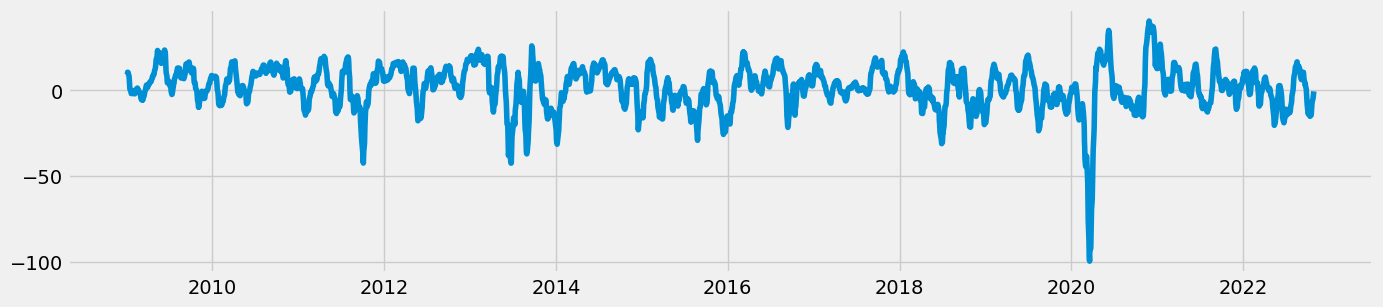

In [59]:
plt.figure(figsize=(15,15))

ax1=plt.subplot(411)
plt.plot(df[TARGET],label=TARGET)
plt.show()


In [60]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    #df['weekofyear'] = df.index.isocalendar().week
    
    
    return df
FEATURES = ['dayofyear', 'dayofweek', 'quarter', 'month', 'year']

df = create_features(df)
df.tail()

,MACD,dayofweek,quarter,month,year,dayofyear,dayofmonth
Date/Time,,,,,,,
2022-10-21,-6.76,4,4,10,2022,294,21
2022-10-25,-4.77,1,4,10,2022,298,25
2022-10-26,-3.57,2,4,10,2022,299,26
2022-10-27,-2.12,3,4,10,2022,300,27
2022-10-28,-0.68,4,4,10,2022,301,28


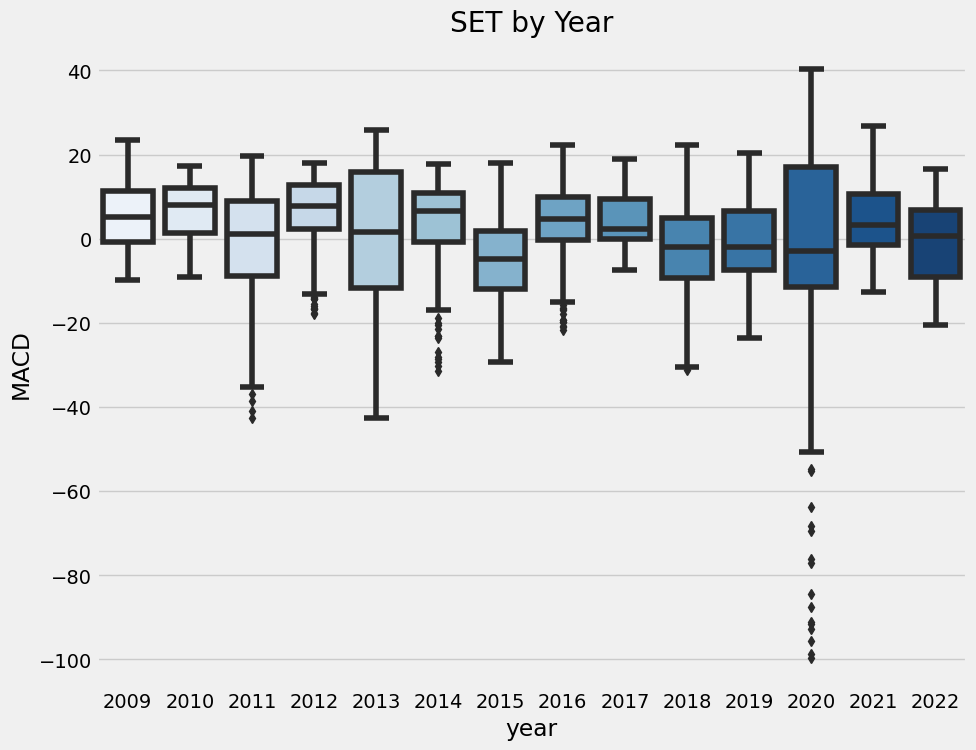

In [61]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='year', y=TARGET, palette='Blues')
ax.set_title(f'{SYMBOL} by Year')
plt.show()

In [62]:
end_period_train='2021-12-31' # start to test



start_period_test='2022-01-01'
end_period_test='2022-06-30'

unseen_period='2022-07'

train = df.loc[:end_period_train,:]
print(train.tail())

test = df.loc[start_period_test:end_period_test,:]
print(test.tail())

unseen=df.loc[unseen_period:,:]
print(unseen.tail())





            MACD  dayofweek  quarter  month  year  dayofyear  dayofmonth
Date/Time                                                               
2021-12-24  3.24          4        4     12  2021        358          24
2021-12-27  3.56          0        4     12  2021        361          27
2021-12-28  4.17          1        4     12  2021        362          28
2021-12-29  5.57          2        4     12  2021        363          29
2021-12-30  6.88          3        4     12  2021        364          30
             MACD  dayofweek  quarter  month  year  dayofyear  dayofmonth
Date/Time                                                                
2022-06-24 -18.14          4        2      6  2022        175          24
2022-06-27 -16.18          0        2      6  2022        178          27
2022-06-28 -13.22          1        2      6  2022        179          28
2022-06-29 -11.51          2        2      6  2022        180          29
2022-06-30 -11.60          3        2      6 

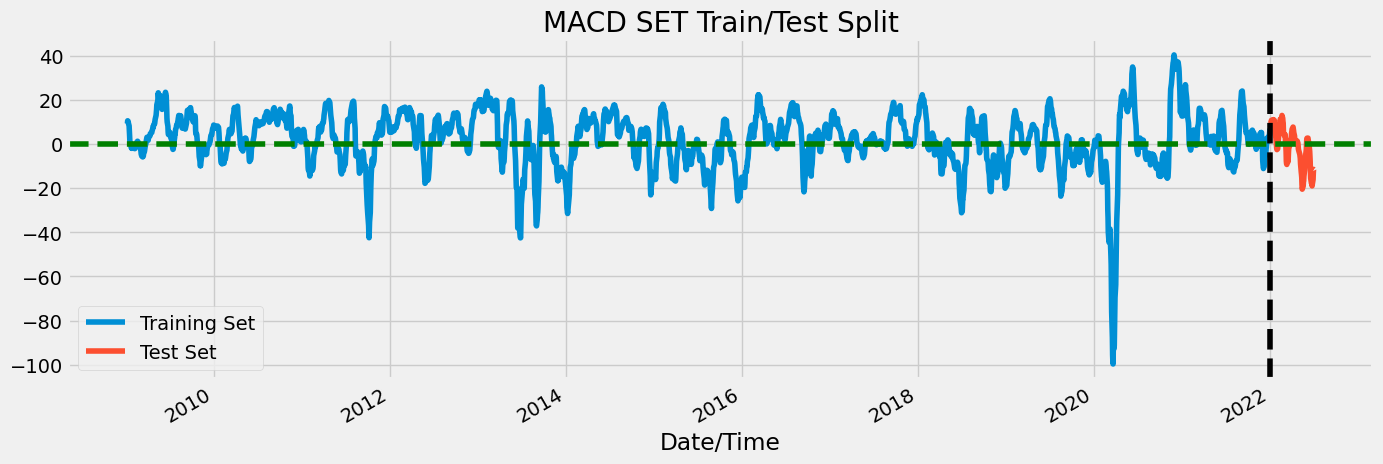

In [63]:
fig, ax = plt.subplots(figsize=(15, 5))
train[TARGET].plot(ax=ax, label='Training Set', title=f'{TARGET} {SYMBOL} Train/Test Split')
test[TARGET].plot(ax=ax, label='Test Set')
ax.axvline(start_period_test, color='black', ls='--')
ax.axhline(Mid_TARGET, color='green', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()


In [64]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_unseen=unseen[FEATURES]

In [65]:
reg = xgb.XGBRegressor( booster='gbtree',    
                       n_estimators=500,
                       early_stopping_rounds=100,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[00:51:56] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:12.99468	validation_1-rmse:8.93989
[100]	validation_0-rmse:12.30003	validation_1-rmse:8.47177
[200]	validation_0-rmse:11.88658	validation_1-rmse:8.69427
[219]	validation_0-rmse:11.75281	validation_1-rmse:8.77763


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=100, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=500, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, ...)

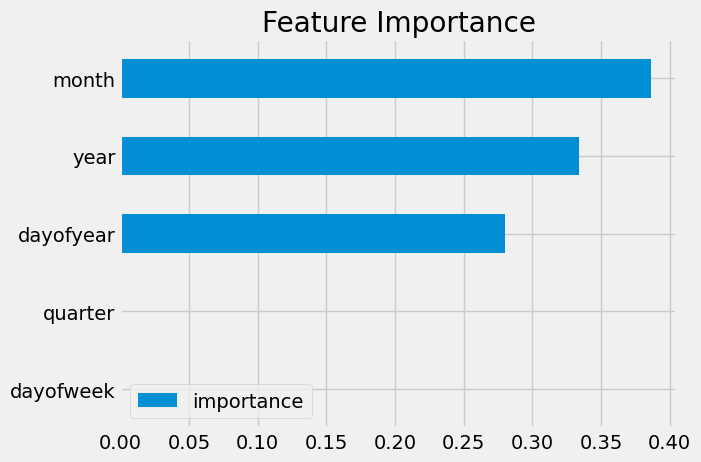

In [66]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [67]:
test[PREDICT_TARGET] = reg.predict(X_test)
df = df.merge(test[[PREDICT_TARGET]], how='left', left_index=True, right_index=True)
print(test.head())
print(test.tail())

             MACD  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
Date/Time                                                                   
2022-01-04   8.82          1        1      1  2022          4           4   
2022-01-05  10.68          2        1      1  2022          5           5   
2022-01-06   9.81          3        1      1  2022          6           6   
2022-01-07   9.39          4        1      1  2022          7           7   
2022-01-10   8.87          0        1      1  2022         10          10   

            Predict-MACD  
Date/Time                 
2022-01-04      6.252689  
2022-01-05      6.252689  
2022-01-06      6.252689  
2022-01-07      6.252689  
2022-01-10      6.252689  
             MACD  dayofweek  quarter  month  year  dayofyear  dayofmonth  \
Date/Time                                                                   
2022-06-24 -18.14          4        2      6  2022        175          24   
2022-06-27 -16.18          0        2   

C:\Users\pongthsa\AppData\Local\Temp\ipykernel_15792\3298771559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[PREDICT_TARGET] = reg.predict(X_test)


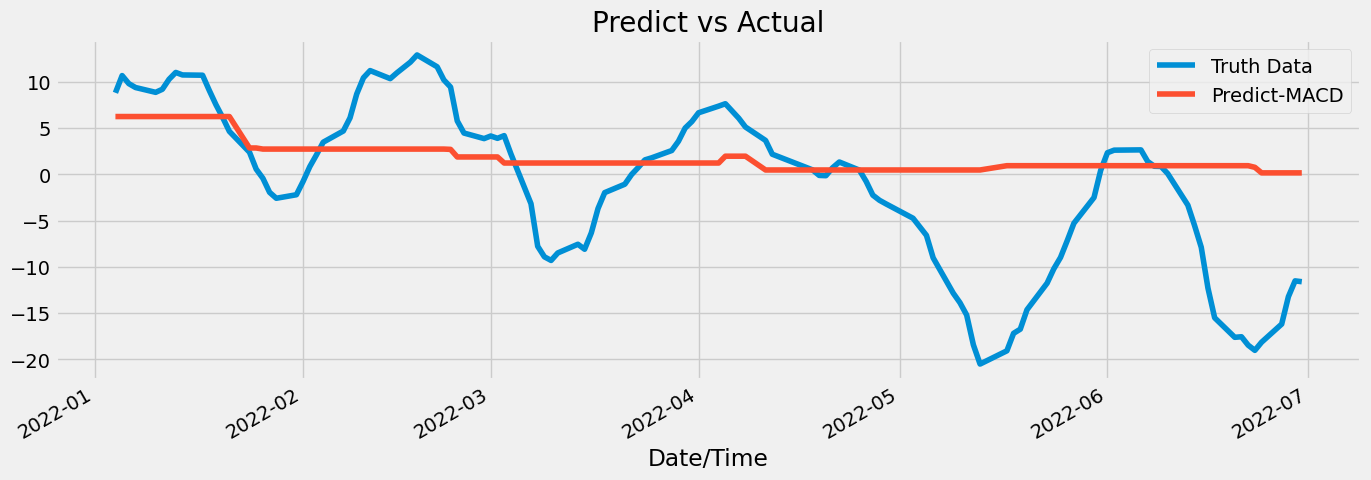

In [68]:
ax = df.loc[start_period_test:end_period_test][TARGET] .plot(figsize=(15, 5), title='Predict vs Actual')
df.loc[ start_period_test:end_period_test][PREDICT_TARGET] .plot(style='-')
plt.legend(['Truth Data',PREDICT_TARGET])
plt.show()

In [69]:
score = np.sqrt(mean_squared_error(test[TARGET], test[PREDICT_TARGET]))
print(f'RMSE Score on Test set: {score:0.2f}')
r2_score = np.sqrt(r2_score(test[TARGET], test[PREDICT_TARGET]))
print(f'R2 Score on Test set: {r2_score :0.2f}')
test['error'] = np.abs(test[TARGET] - test[PREDICT_TARGET])
test['date'] = test.index.date
diff_actual_prediction=test.groupby(['date'])['error'].mean()
diff_actual_prediction.tail(10)

RMSE Score on Test set: 8.38
R2 Score on Test set: 0.31


date
2022-06-17    16.440403
2022-06-20    18.550403
2022-06-21    18.490403
2022-06-22    19.400403
2022-06-23    19.784845
2022-06-24    18.304693
2022-06-27    16.344693
2022-06-28    13.384693
2022-06-29    11.674693
2022-06-30    11.764693
Name: error, dtype: float64